In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
%matplotlib inline
from sklearn.model_selection import train_test_split
from datetime import datetime
from tqdm import tqdm
from sklearn.utils import shuffle
import nltk
import h5py


In [172]:
# %load DNN.py
class DNN():
    
    number = 0
    
    def __init__(self, X_train, y_train, layers, as_placeholders=True, dtypes=[tf.float32,tf.float32]):
        
        self.epsilon = 0.00000001
        self.X_train = X_train
        self.y_train = y_train
        
        if as_placeholders:
            self.X = tf.placeholder(dtype=dtypes[0],shape=(None,)+X_train.shape[1:]) # placeholders have the input diamensions exept the first dimension which is None
            self.y = tf.placeholder(dtype=dtypes[1],shape=(None,)+y_train.shape[1:])
        else:
            # in case DNN object is stacked to another which has placeholders,then it should not have new placeholders
            self.X = X_train
            self.y = y_train
            
        self.layers = layers
        self.activations = [self.X] # initialize first activation with input
        DNN.number +=1
            
    def forward(self): 
        """
            This function forwards the input to the next layer and computes its local forward function.Then accumulates them all. 
            self.activatins[-1] is the last activation
        """
        for i,layer in enumerate(self.layers):
            layer.set_input(self.activations[i])
            self.activations.append(layer.forward())
        return self.activations
    
    def cost(self,cost,*args):
        if cost == 'cross-entropy':
            return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.activations[-1],labels=self.y))
        elif cost == 'mse':
            return tf.losses.mean_squared_error(self.activations[-1],self.y)
        elif cost == 'kld': 
            #def kl_divergence(self,q,p): 
            q = args[0]
            p = args[1]
            kl = (p+self.epsilon) * tf.log((p+self.epsilon)/(q+self.epsilon))
            return tf.reduce_mean(tf.reduce_sum(kl,axis=1))

class DenseLayer():
    
    number = 0
    
    def __init__(self, units, activation_function=tf.nn.relu, batch_norm=False, keep_prob=1.0, initialize_weights=None,\
                 initialize_bias=None, summaries=True,weight_initializer = tf.contrib.layers.xavier_initializer()):
        
        self.units = units
        self.keep_prob = keep_prob
        self.activation_function = activation_function
        self.batch_norm = batch_norm
        self.variable_scope_name = 'Dense-'+str(DenseLayer.number)
        self.initialize_weights = initialize_weights
        self.initialize_bias = initialize_bias
        self.summaries = summaries
        self.weight_initializer = weight_initializer
        DenseLayer.number+=1
        
    def set_input(self,x):
        self.x = x
        if len(x.shape) == 4: # flatten the input if it is a 4d tensor from a convolusion or pooling layer
            shape = self.x.get_shape().as_list()        
            dim = np.prod(shape[1:])
            self.x = tf.reshape(tensor=self.x, shape=[-1,dim])

        with tf.variable_scope(self.variable_scope_name):  
            self.init_W((self.x.get_shape().as_list()[1],self.units))
            self.init_b(self.units)
            if(self.batch_norm):
                self.epsilon = 1e-3
                self.scale = tf.get_variable('scale', initializer=tf.ones(shape=[self.units]))
                self.beta =  tf.get_variable('beta', initializer=tf.zeros(shape=[self.units]))

        
    def init_W(self,shape):       
        if self.initialize_weights is None: 
            self.w=tf.get_variable('weight',shape=shape,initializer=tf.contrib.layers.xavier_initializer())
        else:
            self.w=tf.get_variable('weight',shape=shape,initializer=tf.constant_initializer(self.initialize_weights))
        
        if self.summaries:
            tf.summary.histogram('weight',self.w)
    
    def init_b(self,shape):        
        if self.initialize_bias is None:
            self.b = tf.get_variable('bias',shape=shape, initializer=tf.zeros_initializer())
        else:
           self.b = tf.get_variable('bias',shape=shape, initializer=tf.constant_initializer(self.initialize_bias) )
        if self.summaries:
            tf.summary.histogram('bias',self.b)
        
    def forward(self):
        assert self.x is not None

        #or maybe it is working properly but it needs bigger batch size. like 64. This makes sense because you make estimates of
        #mean and variance for every z calculation. This means that the bigger the batch size the more accurate the estimate
        #batch norm  -------------> TODO needs fixes
        if(self.batch_norm):
            self.z = tf.matmul(self.x,self.w)
            self.batch_mean, self.batch_var = tf.nn.moments(self.z,[0])
            self.z  = tf.nn.batch_normalization(self.z,self.batch_mean,self.batch_var,self.beta,self.scale,self.epsilon)
        else:
            self.z = tf.nn.xw_plus_b(self.x,self.w,self.b)
         
        # activation
        if self.activation_function == None:
            self.activation = self.z
        else:
            self.activation  = self.activation_function(self.z)
        
        # dropout
        self.activation = tf.nn.dropout(self.activation,self.keep_prob)
        
        if self.summaries:
            tf.summary.histogram('activations',self.activation)
        return self.activation
        
class ConvLayer():

    number = 0
    def __init__(self,kernel_size,number_of_kernels,padding='SAME',activation_function=tf.nn.relu,batch_norm = False,keep_prob=1.0):
        self.kernel_size = kernel_size
        self.number_of_kernels = number_of_kernels
        self.padding = padding
        self.activation_function = activation_function
        self.keep_prob = keep_prob
        self.batch_norm = batch_norm
        self.variable_scope_name = 'Conv-'+str(ConvLayer.number)
        ConvLayer.number+=1
        
    def set_input(self,x):
        with tf.variable_scope(self.variable_scope_name):         
            self.x = x
            if(isinstance(self.kernel_size,tuple)):
                self.init_Kernel(self.kernel_size+(x.get_shape().as_list()[-1],self.number_of_kernels))
            else:
                self.init_Kernel((self.kernel_size,self.kernel_size,x.get_shape().as_list()[-1],self.number_of_kernels)) 
            self.init_b(self.number_of_kernels)
            if(self.batch_norm):
                self.epsilon = 1e-3
                self.scale = tf.get_variable('scale', initializer=tf.ones(shape=[self.number_of_kernels]))
                self.beta =  tf.get_variable('beta', initializer=tf.zeros(shape=[self.number_of_kernels]))
        
    def init_Kernel(self,shape):
        self.kernel=tf.get_variable('kernel',shape=shape,initializer=tf.contrib.layers.xavier_initializer())
        tf.summary.histogram('kernel',self.kernel)
        
    def init_b(self,shape):
        self.b = tf.get_variable('bias',shape=[shape],initializer=tf.constant_initializer(0.1))
        tf.summary.histogram('bias',self.b)
        
    def forward(self):
        if self.x == None:
            print('no input defined')
        else:
            if self.batch_norm:
                
                self.z = tf.nn.conv2d(self.x , self.kernel, [1, 1, 1, 1], padding=self.padding)
                self.batch_mean, self.batch_var = tf.nn.moments(self.z,[0,1,2])
                self.z  = tf.nn.batch_normalization(self.z,self.batch_mean,self.batch_var,self.beta,self.scale,self.epsilon)
                
            else:
                self.z = tf.nn.conv2d(self.x , self.kernel, [1, 1, 1, 1], padding=self.padding)
                self.z = tf.nn.bias_add(self.z, self.b)  
                    
            if self.activation_function == None:
                self.activation = self.z
            else:
                self.activation  = self.activation_function(self.z)
            #dropout
            self.activation = tf.nn.dropout(self.activation,self.keep_prob)
            tf.summary.histogram('activations',self.activation)
        return self.activation
        
class PoolingLayer():
    
    number = 0
    
    def __init__(self,kernel_size,stride,padding='SAME',pooling='MAX'):
        self.kernel_size = kernel_size
        self.stride = stride
        self.pooling = pooling
        self.padding = padding
        self.variable_scope_name = 'Pool-'+str(PoolingLayer.number)
        PoolingLayer.number+=1
        
    def set_input(self,x):
        with tf.variable_scope(self.variable_scope_name):         
            self.x = x
        
    def forward(self):
        if self.x == None:
            print('no input defined')
        else:
            if(isinstance(self.kernel_size,tuple)):
                size = list(self.kernel_size)
            else:
                size = [self.kernel_size,self.kernel_size]   
            if (self.pooling == 'MAX'):
                self.activation = tf.nn.max_pool(self.x,[1]+size+[1],[1,self.stride,self.stride,1],padding=self.padding)
            elif (self.pooling == 'AVG'):
                self.activation = tf.nn.avg_pool(self.x,[1]+size+[1],[1,self.stride,self.stride,1],padding=self.padding)
        return self.activation
    
class EmbeddingLayer():
    
    number = 0
    
    def __init__(self,vocabulary_size,embedding_diamension,pretrained_word2vec=True,as_sequences=None):
        self.embedding_diamension = embedding_diamension
        self.vocabulary_size = vocabulary_size
        self.pretrained_word2vec = pretrained_word2vec
        self.variable_scope_name = 'Embedding-'+str(PoolingLayer.number)
        self.init_Embeddings((self.vocabulary_size,self.embedding_diamension))
        self.as_sequences = as_sequences
        EmbeddingLayer.number+=1
        
    def set_input(self,x):
        with tf.variable_scope(self.variable_scope_name):         
            self.x = x
            if self.as_sequences:
                self.sequence_length = x.shape[1]
        
    def init_Embeddings(self,shape):
        with tf.variable_scope(self.variable_scope_name):  
            if(self.pretrained_word2vec):             
                self.W = tf.Variable(tf.constant(0.0, shape=[self.vocabulary_size, self.embedding_diamension]),trainable=True, name="embedding_weights")
                self.embedding_placeholder = tf.placeholder(tf.float32, [self.vocabulary_size, self.embedding_diamension])
                self.embedding_init = self.W.assign(self.embedding_placeholder)
            else:
                self.W = tf.get_variable("embedding_weights", shape=[self.vocabulary_size, self.embedding_diamension],initializer=tf.contrib.layers.xavier_initializer())
    def forward(self):
        # TODO: implement as sequences to provide data for lstm
        if self.x == None:
            print('no input defined')
        else:
            #this is called activation to follow the pattern of other layers
            self.activation = tf.nn.embedding_lookup(self.W, self.x)
            if self.as_sequences == 'static':
                self.activation = tf.transpose(self.activation, [1,0,2])
                self.activation = tf.reshape(self.activation , [-1,self.embedding_diamension])
                self.activation  = tf.split(self.activation ,self.sequence_length,0)
            elif self.as_sequences == 'dynamic':
                pass
            else:
                self.activation = tf.expand_dims(self.activation, -1)        #need 4 diamensions to apply convolution
            return self.activation
class RnnLayer():
    number = 0
    def __init__(self,units,activation_function = None,cell_type = 'LSTM',keep_prob=1.0,rnn_type='static'):
        self.units = units
        self.activation_function = activation_function
        self.keep_prob = keep_prob
        self.cell_type = cell_type
        self.rnn_type = rnn_type
        self.variable_scope_name = 'Rnn-'+str(RnnLayer.number)
        RnnLayer.number+=1
        
    def set_input(self,x):
        with tf.variable_scope(self.variable_scope_name):         
            self.x = x
        
    def forward(self):
        if self.x == None:
            print('no input defined')
        else:
            if self.cell_type == 'LSTM':
                cell = tf.nn.rnn_cell.LSTMCell(self.units,activation=self.activation_function)
                cell = tf.nn.rnn_cell.DropoutWrapper(cell=cell, output_keep_prob=self.keep_prob)
            elif self.cell_type == 'GRU':
                cell = tf.nn.rnn_cell.GRUCell(self.units,activation=self.activation_function)
                cell = tf.nn.rnn_cell.DropoutWrapper(cell=cell, output_keep_prob=self.keep_prob)
                
            #need to fix this
            #self.activation = tf.nn.dynamic_rnn(cell,self.x,sequence_length=self.sequence_length)
            if (self.rnn_type == 'static'):
                self.output, self.states = tf.nn.static_rnn(cell,self.x,dtype=tf.float32)
                self.activation = self.output[-1]
            elif (self.rnn_type == 'dynamic'):
                self.output, self.states = tf.nn.dynamic_rnn(cell,self.x,dtype=tf.float32)
                self.activation = self.output[:,-1,:]
        return self.activation
    

In [82]:
tf.__version__

'1.4.0'

In [138]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('D:/programming/python/datasets/mnist_data', one_hot=True)

X_train = mnist.train.images
y_train = mnist.train.labels
X_test = mnist.test.images
y_test = mnist.test.labels
X_validation = mnist.validation.images
y_validation = mnist.validation.labels
X_train = np.concatenate((X_train,X_test,X_validation))
y_train = np.concatenate((y_train,y_test,y_validation))
y_train = np.argmax(y_train,axis=1).reshape((-1,1)) 

def get_batches(data_list, batch_size,shuffle=True,iterations=None):
    """
    Generates a batch generator for a dataset.
    """
    assert isinstance(data_list,list)
    
    size = data_list[0].shape[0]
    if shuffle:
        shuffle_indices = np.random.permutation(np.arange(size))
        data_list = [i[shuffle_indices] for i in data_list]
        
    number_of_batches = int(np.ceil(size/batch_size))
    for i in range(number_of_batches-1):
        index = i*batch_size
        yield [i[index:index+batch_size] for i in data_list]
    yield[i[(number_of_batches-1)*batch_size:] for i in data_list]

print(X_train.shape[0])

Extracting D:/programming/python/datasets/mnist_data\train-images-idx3-ubyte.gz
Extracting D:/programming/python/datasets/mnist_data\train-labels-idx1-ubyte.gz
Extracting D:/programming/python/datasets/mnist_data\t10k-images-idx3-ubyte.gz
Extracting D:/programming/python/datasets/mnist_data\t10k-labels-idx1-ubyte.gz
70000


In [212]:
class SAE():
    
    def __init__(self,X_train,y_train,layer_dimensions,encoder_weights = None,decoder_weights=None,keep_prob=0.8,\
                 bottleneck_output_activations=[None,None],weight_initializer = tf.contrib.layers.xavier_initializer()):
        self.X_train = X_train
        self.keep_prob = keep_prob
        self.y_train = y_train
        self.weight_initializer = weight_initializer
        self.input_dimensions = X_train.shape[1]
        self.layer_dimensions = layer_dimensions
        self.encoder_weights = encoder_weights
        self.decoder_weights = decoder_weights
        self.init_layers(bottleneck_output_activations)

        
        with tf.variable_scope('encoder'):
            self.encoder = DNN(X_train,X_train,self.encoder_layers)
            self.encoder_activations = self.encoder.forward()
            self.encoder_output = self.encoder_activations[-1]
        with tf.variable_scope('decoder'):
            self.decoder = DNN(self.encoder_output,self.encoder.y,self.decoder_layers,as_placeholders=False)# transfoermed x and previous y which were placeholders
            self.decoder_activations = self.decoder.forward()
    
    def init_layers(self,bottleneck_output_activations):
        
        self.encoder_layers = []
        self.decoder_layers = []
        #encoder    
        for i,diamensions in enumerate(self.layer_dimensions[:-1]):
            if self.encoder_weights is not None:
                self.encoder_layers.append(DenseLayer(diamensions,initialize_weights = self.encoder_weights[i],keep_prob=self.keep_prob))
            else:
                self.encoder_layers.append(DenseLayer(diamensions,keep_prob=self.keep_prob,weight_initializer=self.weight_initializer))
        #encoder bottleneck       
        if self.encoder_weights is not None:    
            self.encoder_layers.append(DenseLayer(self.layer_dimensions[-1],activation_function=bottleneck_output_activations[0],initialize_weights = self.encoder_weights[-1],keep_prob=self.keep_prob)) ##bottleneck layer
        else:
            self.encoder_layers.append(DenseLayer(self.layer_dimensions[-1],activation_function=bottleneck_output_activations[0],keep_prob=self.keep_prob,weight_initializer=self.weight_initializer)) ##bottleneck layer
        #decoder
        for i,dimensions in enumerate(reversed(self.layer_dimensions[:-1])):
            if self.decoder_weights is not None:
                self.decoder_layers.append(DenseLayer(dimensions,initialize_weights = self.decoder_weights[-(i+1)],keep_prob=self.keep_prob))
            else:
                self.decoder_layers.append(DenseLayer(dimensions,keep_prob=self.keep_prob,weight_initializer=self.weight_initializer))
        #decoder output       
        if self.decoder_weights is not None:  
            self.decoder_layers.append(DenseLayer(self.input_dimensions,activation_function=bottleneck_output_activations[1],initialize_weights = self.decoder_weights[0])) 
        else:
            self.decoder_layers.append(DenseLayer(self.input_dimensions,activation_function=bottleneck_output_activations[1],weight_initializer=self.weight_initializer)) #output layer no activation
        
    def fit(self,num_epochs,batch_size,starter_learning_rate=0.1,\
            number_of_decays=3,save_path =None,log_every=20,summaries=False,memory_heavy=False):

        loss = self.squared_cost() # cost is initial cost
        tf.summary.scalar('loss', loss)
        
        learning_rate = tf.placeholder(tf.float32)
        # Passing global_step to minimize() will increment it at each step.
        train = (
            #tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9)
            tf.train.AdamOptimizer()
            .minimize(loss)
        )
 
        merged = tf.summary.merge_all()
    
        if save_path is not None:
            self.saver = tf.train.Saver()

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            if summaries:
                log_name = datetime.now().strftime("%Y%m%d-%H%M%S")
                test_writer = tf.summary.FileWriter('summaries/test/logs'+log_name,sess.graph)
            
            if not memory_heavy:
                feed_dict={self.encoder.X : self.X_train,self.encoder.y : self.X_train}
                cost = sess.run(loss,feed_dict=feed_dict)
                print('initial cost: '+ str(cost))
            #training 
            lr = starter_learning_rate
            for j in range(number_of_decays):
                lr = starter_learning_rate* np.power(10.0, -j)
                print('learning rate: ' + str(lr)+' batch size: '+str(batch_size))
                for i in range(int(num_epochs/number_of_decays)):
                    print(str(i+1)+' epoch out of: '+str(int(num_epochs/number_of_decays)))
                    for c,batch in enumerate(get_batches([self.X_train],batch_size=batch_size)):
                        batch_x = batch[0]
                        feed_dict={self.encoder.X : batch_x,self.encoder.y : batch_x,learning_rate:lr}
                        cost,_= sess.run([loss,train],feed_dict=feed_dict)
                    
                    if not memory_heavy:
                        if i % log_every == 0:
                            feed_dict={self.encoder.X : self.X_train,self.encoder.y : self.X_train}
                            summary,cost = sess.run([merged,loss],feed_dict=feed_dict)
                            if summaries:
                                test_writer.add_summary(summary, i)  
                            print('cost: '+ str(cost))
                    
            if memory_heavy:
                #feedforward with batches
                forwards = []
                number_of_splits = 2
                for c,batch in enumerate(get_batches([self.X_train],batch_size=int(np.floor(X_train.shape[0]/number_of_splits)),shuffle=False)):
                    batch_x = batch[0]
                    feed_dict={self.encoder.X : batch_x,self.encoder.y : batch_x}
                    forwards.append(sess.run(self.encoder_output,feed_dict=feed_dict) )
                self.extract_feature = np.concatenate(forwards,axis=0)            
            else:
                feed_dict={self.encoder.X : self.X_train,self.encoder.y : self.X_train}
                self.extract_feature = sess.run(self.encoder_output,feed_dict=feed_dict)
                
            if save_path is not None:
                print('saving model to '+ save_path)
                self.saver.save(sess, save_path)
        
    def squared_cost(self):
        return tf.losses.mean_squared_error(self.decoder_activations[-1],self.encoder.y)    
    
            

In [232]:
class ClusteringLayer():
    
    number = 0 
    
    def __init__(self, n_clusters, alpha=1.0,initialize_weights = None):
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.variable_scope_name = 'Clustering-'+str(ClusteringLayer.number)
        self.initialize_weights = initialize_weights
        
        ClusteringLayer.number+=1
        
    def set_input(self,x):
        
        self.x = x

        with tf.variable_scope(self.variable_scope_name):  
            self.init_Clusters((self.n_clusters,self.x.get_shape().as_list()[1]))
        
    def init_Clusters(self,shape):
        if self.initialize_weights is None: 
            self.clusters=tf.get_variable('weight',shape=shape,initializer=tf.contrib.layers.xavier_initializer())
        else:
            self.clusters=tf.get_variable('weight',shape=shape,initializer=tf.constant_initializer(self.initialize_weights))
        tf.summary.histogram('weight',self.clusters)
        
    def forward(self):
        if self.x == None:
            print('no input defined')
        else:
            with tf.name_scope('students_t'):
                q = 1.0 / (1.0 + (tf.reduce_sum(tf.square(tf.expand_dims(self.x, axis=1) - self.clusters), axis=2) / self.alpha))
                q **= (self.alpha + 1.0) / 2.0
                q = tf.transpose(tf.transpose(q) / tf.reduce_sum(q, axis=1))
                return q

    

In [207]:
def reset():
    tf.reset_default_graph()
    DenseLayer.number = 0
    ConvLayer.number = 0
    PoolingLayer.number = 0
    EmbeddingLayer.number = 0
    RnnLayer.number = 0
    SAE.number = 0
    
#restore the weights i need from the encoder   
def restore_variables(file,variable_name,scope=None):
    reset()
    with tf.Session() as sess:
        saver = tf.train.import_meta_graph(file+'.meta')##copies the graph
        saver.restore(sess,file) ## restores the variables to the graph. no need to initialize variables as this functions makes the initalization
        graph = tf.get_default_graph()
        variables=[]
        for i in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=scope):
            if variable_name in  i.name:
                variables.append(graph.get_tensor_by_name(i.name).eval())
                print(i)
        return variables
    


In [202]:
# slice_path = './model_v2/autoencoder_'
# #layer_wise training    
# layers = [500,500,2000,10]
# layer_input = X_train
# for i,layer in enumerate(layers):
#     reset()
#     if i == 0:
#         activations = [tf.nn.relu,None]
#     elif i == len(layers) -1:
#         activations = [None,tf.nn.relu]
#     else:
#         activations = [tf.nn.relu,tf.nn.relu]
#     sae = SAE(layer_input,y_train,[layer],bottleneck_output_activations=activations,keep_prob=0.8)
#     sae.fit(600,256,save_path=slice_path+str(i),log_every=5,number_of_decays=1,memory_heavy=True)
#     layer_input = sae.extract_feature

In [ ]:
# #pretrain full encoder
# full_path = './model_v2/full_autoencoder'
# reset()
# encoder_weights = []
# decoder_weights = []
# layers = [500,500,2000,10]
# for i,layer in enumerate(layers):
#     encoder_weights.append(restore_variables(slice_path+str(i),'weight:0','encoder')[-1])
#     decoder_weights.append(restore_variables(slice_path+str(i),'weight:0','decoder')[-1])
# reset()
# #full auto-encoder without dropout
# full_sae = SAE(X_train,y_train,layers,encoder_weights=encoder_weights,decoder_weights= decoder_weights,keep_prob=1.0)
# #full_sae = SAE(X_train,y_train,layers,keep_prob=1.0)
# full_sae.fit(300,256,starter_learning_rate=1,number_of_decays=1,save_path=full_path,log_every=20,memory_heavy=False)
# print(full_sae.extract_feature.shape)

In [221]:
#pretrain full encoder with greedy pretraining
full_path = './model_v2_adam/full_autoencoder'
reset()
layers = [500,500,2000,10]
init = tf.contrib.layers.variance_scaling_initializer(factor=1. / 3, mode='FAN_IN', uniform=True, seed=None, dtype=tf.float32)
full_sae = SAE(X_train,y_train,layers,keep_prob=1.0,weight_initializer=init)
full_sae.fit(300,256,starter_learning_rate=1,number_of_decays=1,save_path=full_path,log_every=30,memory_heavy=False)
print(full_sae.extract_feature.shape)

initial cost: 0.112402
learning rate: 1.0 batch size: 256
1 epoch out of: 300
cost: 0.0257195
2 epoch out of: 300
3 epoch out of: 300
4 epoch out of: 300
5 epoch out of: 300
6 epoch out of: 300
7 epoch out of: 300
8 epoch out of: 300
9 epoch out of: 300
10 epoch out of: 300
11 epoch out of: 300
12 epoch out of: 300
13 epoch out of: 300
14 epoch out of: 300
15 epoch out of: 300
16 epoch out of: 300
17 epoch out of: 300
18 epoch out of: 300
19 epoch out of: 300
20 epoch out of: 300
21 epoch out of: 300
22 epoch out of: 300
23 epoch out of: 300
24 epoch out of: 300
25 epoch out of: 300
26 epoch out of: 300
27 epoch out of: 300
28 epoch out of: 300
29 epoch out of: 300
30 epoch out of: 300
31 epoch out of: 300
cost: 0.0108615
32 epoch out of: 300
33 epoch out of: 300
34 epoch out of: 300
35 epoch out of: 300
36 epoch out of: 300
37 epoch out of: 300
38 epoch out of: 300
39 epoch out of: 300
40 epoch out of: 300
41 epoch out of: 300
42 epoch out of: 300
43 epoch out of: 300
44 epoch out of:

In [219]:
full_path = './model_v2_2/full_autoencoder'
weights  = restore_variables(full_path,'weight:0','encoder')
biases  = restore_variables(full_path,'bias:0','encoder')
for i in weights:
    print(i.sum())

INFO:tensorflow:Restoring parameters from ./model_v2_2/full_autoencoder
<tf.Variable 'encoder/Dense-0/weight:0' shape=(784, 500) dtype=float32_ref>
<tf.Variable 'encoder/Dense-1/weight:0' shape=(500, 500) dtype=float32_ref>
<tf.Variable 'encoder/Dense-2/weight:0' shape=(500, 2000) dtype=float32_ref>
<tf.Variable 'encoder/Dense-3/weight:0' shape=(2000, 10) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from ./model_v2_2/full_autoencoder
<tf.Variable 'encoder/Dense-0/bias:0' shape=(500,) dtype=float32_ref>
<tf.Variable 'encoder/Dense-1/bias:0' shape=(500,) dtype=float32_ref>
<tf.Variable 'encoder/Dense-2/bias:0' shape=(2000,) dtype=float32_ref>
<tf.Variable 'encoder/Dense-3/bias:0' shape=(10,) dtype=float32_ref>
-122.764
-173.336
-784.422
-5.56402


In [233]:
from sklearn.cluster import KMeans
tf.reset_default_graph()
DenseLayer.number = 0
ConvLayer.number = 0
PoolingLayer.number = 0
EmbeddingLayer.number = 0
RnnLayer.number = 0
SAE.number = 0
ClusteringLayer.number = 0

def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

def target_distribution_np(q):
    weight = np.square(q) / np.sum(q,axis=0)
    return np.transpose( np.transpose(weight) /np.sum(weight,axis=1))

# def target_distribution(q):
#     with tf.name_scope('target_distribution'):
#         weight = tf.square(q) / tf.reduce_sum(q,axis=0)
#         return tf.transpose( tf.transpose(weight) /tf.reduce_sum(weight,axis=1))

print(X_train.shape[0])

p = tf.placeholder(dtype=tf.float32,shape=(None,10))

#create encoder with pretrained weights
encoder = DNN(X_train,y_train,[DenseLayer(500,initialize_weights=weights[0],initialize_bias=biases[0]),DenseLayer(500,initialize_weights=weights[1],initialize_bias=biases[1]),\
                               DenseLayer(2000,initialize_weights=weights[2],initialize_bias=biases[2]),DenseLayer(10,initialize_weights=weights[3],initialize_bias=biases[3],activation_function=None),\
                                ],dtypes=[tf.float32,tf.int32])

# encoder = DNN(X_train,y_train,[DenseLayer(500),DenseLayer(500),\
#                                DenseLayer(2000),DenseLayer(10,activation_function=None),\
#                                 ],dtypes=[tf.float32,tf.int32])

encoder_output = encoder.forward()[-1]
#get encoder features
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    features = sess.run(encoder_output,feed_dict={encoder.X:X_train})

#get kmean weights to initialize clustering layer
print('initializing kmeans clusters ')
n_clusters=10
km = KMeans(n_clusters, n_init=20)
y_pred = km.fit_predict(features)
kmeans_weights =km.cluster_centers_ 

clustering = DNN(encoder_output,encoder.y,[ClusteringLayer(10,initialize_weights=kmeans_weights)],as_placeholders=False)
clustering_activations = clustering.forward()
q = clustering_activations[-1]

kld_cost = encoder.cost('kld',q,p)
tf.summary.scalar('loss',kld_cost)
optimizer = tf.train.MomentumOptimizer(0.01,0.9)
##optimizer = tf.train.AdamOptimizer(0.01)
train = optimizer.minimize(kld_cost)

merged = tf.summary.merge_all()

batch_size = 256
tol=1e-3
update_rate = 140 # epochs
#######ITERS
iters = 20000

size = X_train.shape[0]
number_of_batches = np.ceil(size/batch_size)
index = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
#     log_name = datetime.now().strftime("%Y%m%d-%H%M%S")
#     #train_writer = tf.summary.FileWriter('summaries/train/logs'+log_name,sess.graph)
#     test_writer = tf.summary.FileWriter('summaries/test/logs'+log_name,sess.graph)
    
    #print(sess.run(tf.reduce_sum(encoder.layers[0].w)))
    
    q_value=sess.run(q,feed_dict={encoder.X : X_train})  
    p_value = target_distribution_np(q_value)

    
    #training 
    for i in range(iters):
        
        data = [X_train,y_train,p_value]

        if index == number_of_batches-1:
            batch = [d[index*batch_size:] for d in data]
            batch_x = batch[0]
            batch_y = batch[1]
            batch_p = batch[2]
            index=0
        else:
            batch = [d[index*batch_size:(index+1)*batch_size] for d in data]
            batch_x = batch[0]
            batch_y = batch[1]
            batch_p = batch[2]
            index+=1
        
        if (i) % update_rate == 0:
            q_value=sess.run(q,feed_dict={encoder.X : X_train})  
            p_value = target_distribution_np(q_value)
            q_value_batch,cost=sess.run([q,kld_cost],feed_dict={encoder.X:X_train , p:p_value}) 
            train_acc = cluster_acc(y_train,np.argmax(q_value_batch,axis=1).reshape(-1,1))
            print("overall cost: "+str(cost)+"\t overall accuracy: "+ str(train_acc)+" in " + str(i) + ' iteration')

        
        _=sess.run(train,feed_dict={encoder.X:batch_x , p:batch_p}) 
        #batch_train_acc = cluster_acc(batch_y,np.argmax(q_value,axis=1).reshape(-1,1))



70000
initializing kmeans clusters 
overall cost: 0.190865	 overall accuracy: 0.817685714286 in 0 iteration
overall cost: 0.278171	 overall accuracy: 0.831628571429 in 140 iteration
overall cost: 0.270635	 overall accuracy: 0.842171428571 in 280 iteration
overall cost: 0.262248	 overall accuracy: 0.848614285714 in 420 iteration
overall cost: 0.252481	 overall accuracy: 0.850714285714 in 560 iteration
overall cost: 0.241703	 overall accuracy: 0.852714285714 in 700 iteration
overall cost: 0.232455	 overall accuracy: 0.853128571429 in 840 iteration
overall cost: 0.224468	 overall accuracy: 0.854385714286 in 980 iteration
overall cost: 0.217698	 overall accuracy: 0.855042857143 in 1120 iteration
overall cost: 0.21045	 overall accuracy: 0.8556 in 1260 iteration
overall cost: 0.204343	 overall accuracy: 0.856385714286 in 1400 iteration
overall cost: 0.198398	 overall accuracy: 0.856442857143 in 1540 iteration
overall cost: 0.193712	 overall accuracy: 0.857057142857 in 1680 iteration
overall 

KeyboardInterrupt: 

In [222]:
from sklearn.cluster import KMeans
print('performing k-means clustering on the extracted features')

n_clusters=10
print(full_sae.extract_feature.shape)
km = KMeans(n_clusters, n_init=20)
y_pred = km.fit_predict(full_sae.extract_feature)
y = y_train.reshape(-1)
from sklearn.metrics import normalized_mutual_info_score as nmi
print('K-means clustering result on extracted features: NMI = '+str(nmi(y, y_pred)))
print('K-means clustering result on extracted features: accuracy = '+str(cluster_acc(y, y_pred)))


performing k-means clustering on the extracted features
(70000, 10)
K-means clustering result on extracted features: NMI = 0.78374562164
K-means clustering result on extracted features: accuracy = 0.797971428571


In [15]:
from sklearn.cluster import KMeans
print('performing k-means clustering on input')

n_clusters=10
print(X_train.shape)
km = KMeans(n_clusters, n_init=20)
y_pred = km.fit_predict(X_train)
y = y_train.reshape(-1)
from sklearn.metrics import normalized_mutual_info_score as nmi
print('K-means clustering result on extracted features: NMI = '+str(nmi(y, y_pred)))
print('K-means clustering result on extracted features: accuracy = '+str(cluster_acc(y, y_pred)))

performing k-means clustering on input
(55000, 784)
K-means clustering result on extracted features: NMI = 0.492098303127
K-means clustering result on extracted features: accuracy = 0.516618181818


[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 2.341622
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.397122
[t-SNE] Error after 300 iterations: 1.397122
(70000, 784)
(70000, 1)
t-SNE done! Time elapsed: 102.98713827133179 seconds


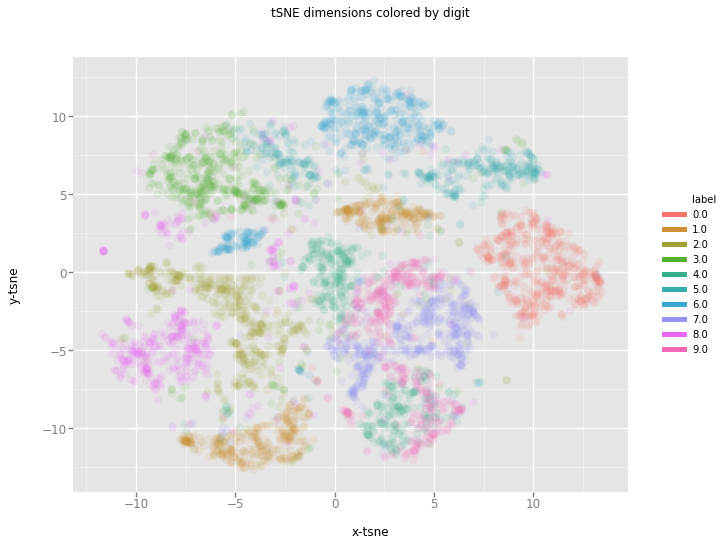

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.985663
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.345583
[t-SNE] Error after 300 iterations: 1.345583
(70000, 10)
(70000, 1)
t-SNE done! Time elapsed: 79.68915104866028 seconds


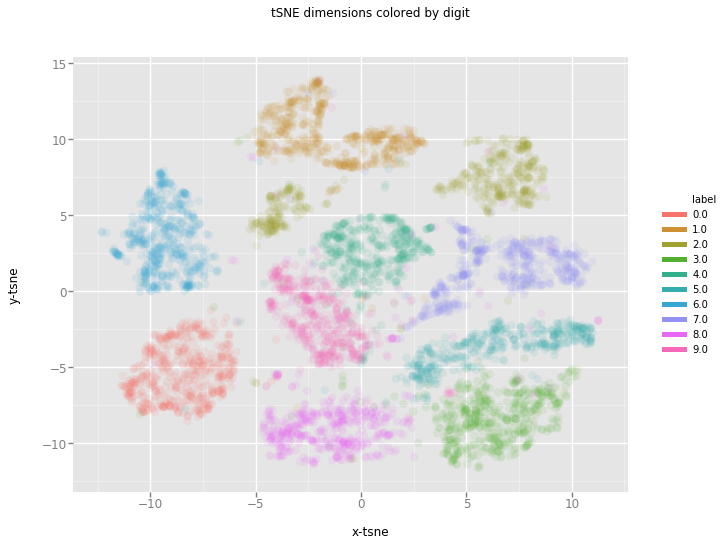

In [199]:
import time
from sklearn.manifold import TSNE
from ggplot import *

def tsne(x,y,n_sne):  
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(x[:n_sne])
    print(x.shape)
    print(y.shape)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    x_tsne = np.expand_dims(tsne_results[:,0],1)
    y_tsne = np.expand_dims(tsne_results[:,1],1)
    label = np.int32(y[:n_sne])
    data = np.concatenate((x_tsne,y_tsne,label),axis=1)

    df_tsne = pd.DataFrame(data=data,columns=['x-tsne','y-tsne','label'])
    df_tsne.label  = df_tsne.label.map(lambda x:  str(x))
    chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
            + geom_point(size=70,alpha=0.1) \
            + ggtitle("tSNE dimensions colored by digit")
    chart.show()
tsne(X_train,y_train,5000)
tsne(full_sae.extract_feature,y_train,5000)